<a href="https://colab.research.google.com/github/mecatronico-consultor/ppg-bgl-estimation-using-mfcc-features/blob/main/MUST_ppg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# CELDA 1: INSTALACIÓN E IMPORTACIÓN
# ==========================================
# Instalamos librosa para los cálculos de audio/frecuencia
!pip install librosa scikit-learn pandas scipy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
import librosa
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

print("Librerías instaladas y cargadas correctamente.")

Librerías instaladas y cargadas correctamente.


In [ ]:
# ==========================================
# CELDA 2: CONFIGURACIÓN de parámetros
# ==========================================

# Frecuencia de muestreo del sensor (Hz).
# El paper usa 2175 Hz[cite: 327]. A esta frecuencia el sensor adquirió las señales
FS = 2175

#Parámetros del método SDFMFCC [cite: 263-267]
WINDOW_EXT_MS = 20  # Extensión de la ventana en ms a cada lado de los picos [cite: 158]
MFCC_COEFFS = 12    # Número de coeficientes cepstrales [cite: 264]
N_MELS = 20         # Número de bancos de filtros Mel [cite: 263]
FREQ_MIN = 1        # Frecuencia mínima en Hz [cite: 266]
FREQ_MAX = 4.5      # Frecuencia máxima en Hz (rango PPG) [cite: 266]

print(f"Configuración cargada: FS={FS}Hz, MFCC={MFCC_COEFFS}")

Configuración cargada: FS=2175Hz, MFCC=12


In [ ]:
# ==========================================
# CELDA 3: FUNCIÓN DE EXTRACCIÓN
# ==========================================
import warnings

def extract_sdfmfcc_features(signal_values, fs):
    """
    Versión mejorada con alta resolución espectral (Zero-Padding)
    para evitar el error 'Empty filters' en rangos de baja frecuencia.
    """
    # 1. Suavizado (Savitzky-Golay)
    window_length = 15
    polyorder = 3
    try:
        smooth_signal = savgol_filter(signal_values, window_length=window_length, polyorder=polyorder)
    except ValueError:
        smooth_signal = signal_values

    # 2. Detección de Picos
    distance_samples = int(fs / 3.5) # Aprox. para evitar falsos positivos
    systolic_peaks, _ = find_peaks(smooth_signal, distance=distance_samples)
    diastolic_peaks, _ = find_peaks(-smooth_signal, distance=distance_samples)

    # 3. Framing (Segmentación)
    ext_samples = int((WINDOW_EXT_MS / 1000) * fs)
    mfcc_features_list = []

    # Unir y ordenar puntos
    all_points = []
    for p in systolic_peaks: all_points.append((p, 'S'))
    for p in diastolic_peaks: all_points.append((p, 'D'))
    all_points.sort(key=lambda x: x[0])

    # Recorrer segmentos
    for i in range(len(all_points) - 1):
        idx_curr, _ = all_points[i]
        idx_next, _ = all_points[i+1]

        start = max(0, idx_curr - ext_samples)
        end = min(len(signal_values), idx_next + ext_samples)
        segment = signal_values[start:end]

        if len(segment) < 10: continue

        # --- CORRECCIÓN CLAVE ---
        segment = segment.astype(float)

        # Usamos un n_fft MUY grande para tener resolución en 1-4.5 Hz
        # Resolución = Fs / n_fft.
        # 2175 / 16384 ≈ 0.13 Hz (suficiente para separar los 20 filtros)
        n_fft_high_res = 16384

        try:
            # Suprimimos los warnings de librosa temporalmente para limpiar la salida
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                mfccs = librosa.feature.mfcc(y=segment, sr=fs,
                                             n_mfcc=MFCC_COEFFS,
                                             n_mels=N_MELS,
                                             fmin=FREQ_MIN, fmax=FREQ_MAX,
                                             n_fft=n_fft_high_res,
                                             hop_length=len(segment)+1, # Un solo frame por segmento
                                             center=True) # Center=True ayuda con el padding

            # Tomamos la media (aunque con hop_length grande suele salir 1 columna)
            mfcc_mean = np.mean(mfccs, axis=1)

            # Validación extra: si sale todo ceros o NaNs, ignorar
            if not np.all(mfcc_mean == 0) and not np.isnan(mfcc_mean).any():
                mfcc_features_list.append(mfcc_mean)

        except Exception as e:
            # print(f"Error en segmento: {e}")
            continue

    if not mfcc_features_list:
        return np.zeros(MFCC_COEFFS)

    return np.mean(mfcc_features_list, axis=0)

print("Función SDFMFCC corregida con Alta Resolución (n_fft=16384).")

Función SDFMFCC corregida con Alta Resolución (n_fft=16384).


In [ ]:
# ==========================================
# CELDA 4 CORREGIDA: CARGA DE DATOS (FIX IDs 01-09)
# ==========================================
from google.colab import drive
import os
import pandas as pd
import numpy as np

# 1. Montar Drive (si no está montado)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. DEFINIR RUTA (Ajusta esto si cambiaste la carpeta)
# Según tu diagnóstico, esta es la ruta correcta:
RUTA_EN_DRIVE = '/content/drive/MyDrive/Colab Notebooks/MUST PPG'

print(f"Buscando archivos en: {RUTA_EN_DRIVE}")

if not os.path.exists(RUTA_EN_DRIVE):
    print(f"¡ERROR! La ruta no existe.")
else:
    path_total = os.path.join(RUTA_EN_DRIVE, 'Total.csv')

    if os.path.exists(path_total):
        df_total = pd.read_csv(path_total)
        # Contador de mediciones
        df_total['measurement_num'] = df_total.groupby('ID').cumcount() + 1

        X = []
        Y = []
        found_files = 0

        print("Procesando señales...")

        for index, row in df_total.iterrows():
            p_id = row['ID']
            m_num = row['measurement_num']

            # --- CORRECCIÓN AQUÍ ---
            # {p_id:02d} fuerza que el 1 se convierta en "01"
            file_name_base = f"signal_{p_id:02d}_{m_num:04d}"

            # Construir rutas posibles
            full_path_csv = os.path.join(RUTA_EN_DRIVE, file_name_base + ".csv")

            # Verificar existencia
            if os.path.exists(full_path_csv):
                try:
                    # Leer señal
                    signal_df = pd.read_csv(full_path_csv, header=None)
                    signal_vals = pd.to_numeric(signal_df.iloc[:, 0], errors='coerce').dropna().values

                    if len(signal_vals) > 100:
                        # Llamada a la función SDFMFCC (Asegúrate de haber corrido Celda 3)
                        feats = extract_sdfmfcc_features(signal_vals, FS)

                        # Si no devolvió ceros (error), guardar
                        if not np.all(feats == 0):
                            X.append(feats)
                            Y.append(row['Glucose'])
                            found_files += 1
                        else:
                            print(f"Advertencia: Características vacías en {file_name_base}")

                except Exception as e:
                    print(f"Error leyendo {file_name_base}: {e}")
            else:
                # Si falla, intentamos sin el padding por si acaso hay mezcla de formatos
                # (Fallback para IDs tipo '10' que a veces no llevan 0 delante, aunque :02d lo maneja bien)
                pass
                # print(f"No encontrado: {file_name_base}")

        X = np.array(X)
        Y = np.array(Y)

        print(f"\nProceso terminado.")
        print(f"Archivos procesados exitosamente: {found_files} de {len(df_total)}")

    else:
        print("No se encontró 'Total.csv'.")

Buscando archivos en: /content/drive/MyDrive/Colab Notebooks/MUST PPG
Procesando señales...

Proceso terminado.
Archivos procesados exitosamente: 67 de 67


Entrenando modelo SVR (Kernel RBF)...

Resultados:
RMSE: 26.07 mg/dL (Objetivo paper: ~26.01)
MAE:  17.84 mg/dL
MARD: 13.20 %


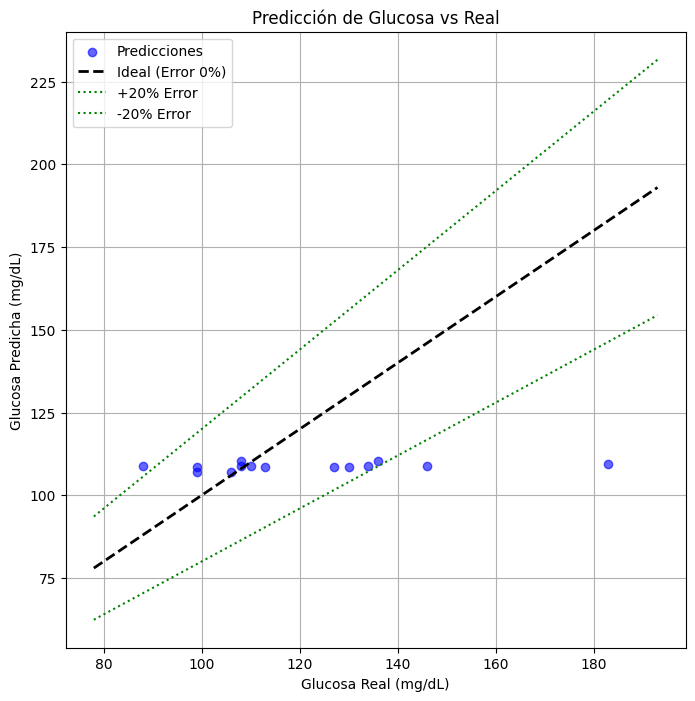

In [ ]:
# ==========================================
# CELDA 5: ENTRENAMIENTO Y EVALUACIÓN
# ==========================================
if len(X) > 0:
    # 1. División Train/Test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # 2. Escalado (Normalización) - CRÍTICO para SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # [cite_start]3. Configuración SVR según el Paper [cite: 285]
    print("Entrenando modelo SVR (Kernel RBF)...")
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
    svr.fit(X_train_scaled, y_train)

    # 4. Predicción
    y_pred = svr.predict(X_test_scaled)

    # 5. Métricas de Error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mard = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"\nResultados:")
    print(f"RMSE: {rmse:.2f} mg/dL (Objetivo paper: ~26.01)")
    print(f"MAE:  {mae:.2f} mg/dL")
    print(f"MARD: {mard:.2f} %")

    # 6. Gráfica de Dispersión (Clarke Grid simplificado)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.6, label='Predicciones')

    # Línea ideal
    min_val = min(min(y_test), min(y_pred)) - 10
    max_val = max(max(y_test), max(y_pred)) + 10
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal (Error 0%)')

    # Líneas de error del 20% (Zona A aprox)
    plt.plot([min_val, max_val], [min_val*1.2, max_val*1.2], 'g:', label='+20% Error')
    plt.plot([min_val, max_val], [min_val*0.8, max_val*0.8], 'g:', label='-20% Error')

    plt.title('Predicción de Glucosa vs Real')
    plt.xlabel('Glucosa Real (mg/dL)')
    plt.ylabel('Glucosa Predicha (mg/dL)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Error: No hay datos para entrenar. Verifica la celda 4.")

Iniciando Validación Cruzada con 67 muestras...

Ronda | RMSE       | MAE        | MARD      
---------------------------------------------
1     | 26.07      | 17.84      | 13.20     %
2     | 10.36      | 8.37       | 7.31      %
3     | 28.00      | 20.47      | 14.51     %
4     | 12.47      | 9.21       | 8.61      %
5     | 13.75      | 11.14      | 9.89      %
---------------------------------------------

--- RESULTADOS FINALES (PROMEDIO) ---
RMSE Promedio: 18.13 mg/dL (Paper: 26.01)
MAE Promedio:  13.40 mg/dL
MARD Promedio: 10.70 %


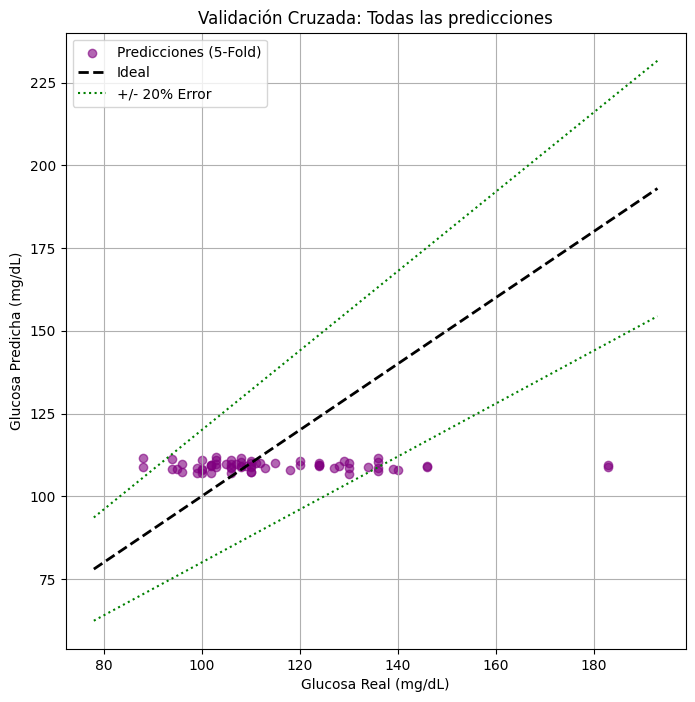

In [ ]:
# ==========================================
# CELDA 6: VALIDACIÓN CRUZADA (5-FOLD CV)
# ==========================================
from sklearn.model_selection import KFold

if len(X) > 0:
    print(f"Iniciando Validación Cruzada con {len(X)} muestras...")

    # 1. Configurar K-Fold (5 particiones, barajando datos)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Listas para guardar los resultados de cada ronda
    rmses = []
    maes = []
    mards = []

    # Listas para guardar TODAS las predicciones y graficarlas juntas al final
    y_real_total = []
    y_pred_total = []

    fold_count = 1

    print(f"\n{'Ronda':<5} | {'RMSE':<10} | {'MAE':<10} | {'MARD':<10}")
    print("-" * 45)

    # 2. Bucle de Validación
    for train_index, test_index in kf.split(X):
        # Separar datos
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = Y[train_index], Y[test_index]

        # Escalar (¡Importante escalar DENTRO del bucle para no filtrar info!)
        scaler_cv = StandardScaler()
        X_train_cv = scaler_cv.fit_transform(X_train_cv)
        X_test_cv = scaler_cv.transform(X_test_cv)

        # Entrenar modelo
        svr_cv = SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
        svr_cv.fit(X_train_cv, y_train_cv)

        # Predecir
        y_pred_cv = svr_cv.predict(X_test_cv)

        # Calcular métricas de esta ronda
        rmse_fold = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
        mae_fold = mean_absolute_error(y_test_cv, y_pred_cv)
        mard_fold = np.mean(np.abs((y_test_cv - y_pred_cv) / y_test_cv)) * 100

        # Guardar resultados
        rmses.append(rmse_fold)
        maes.append(mae_fold)
        mards.append(mard_fold)

        # Acumular para gráfica final
        y_real_total.extend(y_test_cv)
        y_pred_total.extend(y_pred_cv)

        print(f"{fold_count:<5} | {rmse_fold:<10.2f} | {mae_fold:<10.2f} | {mard_fold:<10.2f}%")
        fold_count += 1

    # 3. Resultados Promedio
    print("-" * 45)
    print(f"\n--- RESULTADOS FINALES (PROMEDIO) ---")
    print(f"RMSE Promedio: {np.mean(rmses):.2f} mg/dL (Paper: 26.01)")
    print(f"MAE Promedio:  {np.mean(maes):.2f} mg/dL")
    print(f"MARD Promedio: {np.mean(mards):.2f} %")

    # 4. Gráfica Global (Clarke Grid simplificado con todos los datos)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_real_total, y_pred_total, c='purple', alpha=0.6, label='Predicciones (5-Fold)')

    # Línea ideal
    all_min = min(min(y_real_total), min(y_pred_total)) - 10
    all_max = max(max(y_real_total), max(y_pred_total)) + 10
    plt.plot([all_min, all_max], [all_min, all_max], 'k--', lw=2, label='Ideal')

    # Líneas de error +/- 20%
    plt.plot([all_min, all_max], [all_min*1.2, all_max*1.2], 'g:', label='+/- 20% Error')
    plt.plot([all_min, all_max], [all_min*0.8, all_max*0.8], 'g:')

    plt.title('Validación Cruzada: Todas las predicciones')
    plt.xlabel('Glucosa Real (mg/dL)')
    plt.ylabel('Glucosa Predicha (mg/dL)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("No hay datos cargados en X. Ejecuta la celda 4 primero.")

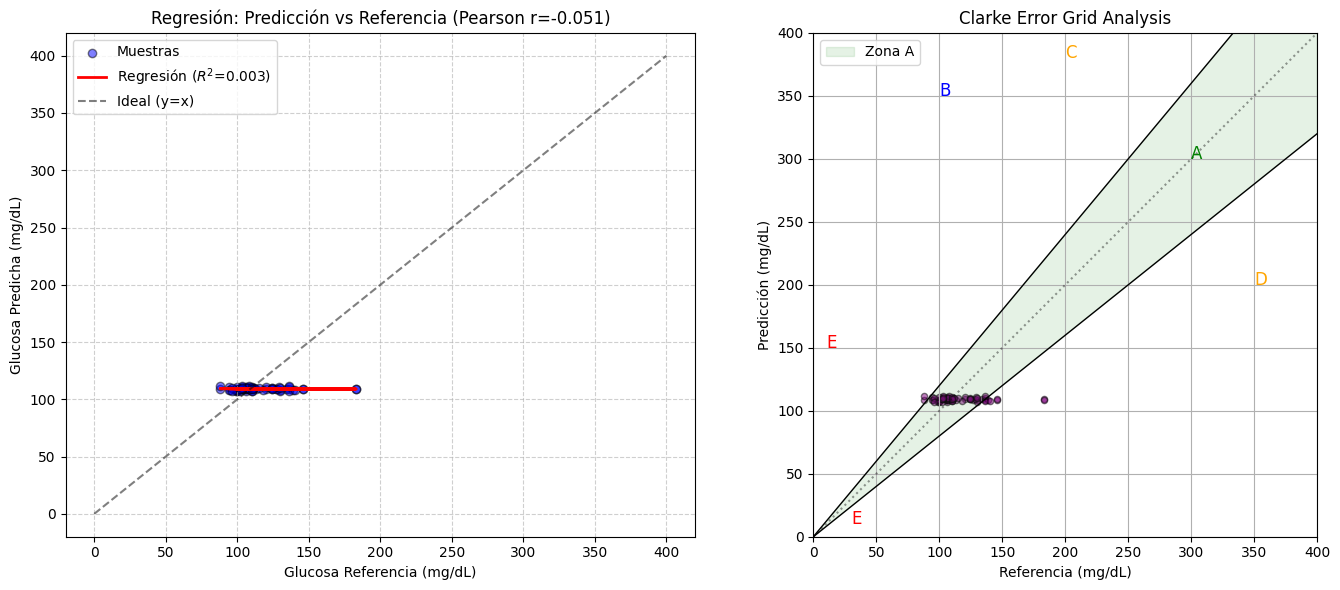


--- ANÁLISIS CLÍNICO ---
Coeficiente de Correlación (Pearson r): -0.0510 (Paper: 0.996)
Muestras en Zona A (aprox): 85.07% (Paper: 99.27%)


In [ ]:
# ==========================================
# CELDA 7: GRAFICACIÓN PROFESIONAL
# ==========================================
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# Verificar que existan los datos de la Validación Cruzada
if 'y_real_total' in locals() and 'y_pred_total' in locals():

    y_real = np.array(y_real_total)
    y_pred = np.array(y_pred_total)

    # --- GRÁFICO 1: ANÁLISIS DE REGRESIÓN ---
    plt.figure(figsize=(14, 6))

    # Subplot 1: Dispersión y Regresión
    plt.subplot(1, 2, 1)

    # Calcular correlación de Pearson
    corr, _ = pearsonr(y_real, y_pred)

    # Ajuste lineal (m*x + b)
    m, b = np.polyfit(y_real, y_pred, 1)

    plt.scatter(y_real, y_pred, c='blue', alpha=0.5, edgecolors='k', label='Muestras')
    plt.plot(y_real, m*y_real + b, 'r-', lw=2, label=f'Regresión ($R^2$={corr**2:.3f})')
    plt.plot([0, 400], [0, 400], 'k--', alpha=0.5, label='Ideal (y=x)')

    plt.title(f'Regresión: Predicción vs Referencia (Pearson r={corr:.3f})')
    plt.xlabel('Glucosa Referencia (mg/dL)')
    plt.ylabel('Glucosa Predicha (mg/dL)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)


    # --- GRÁFICO 2: CLARKE ERROR GRID (Implementación Estándar) ---
    plt.subplot(1, 2, 2)

    # Definición de zonas para Clarke Grid
    plt.scatter(y_real, y_pred, c='purple', alpha=0.5, s=20, edgecolors='k')
    plt.title('Clarke Error Grid Analysis')
    plt.xlabel('Referencia (mg/dL)')
    plt.ylabel('Predicción (mg/dL)')
    plt.xlim(0, 400)
    plt.ylim(0, 400)
    plt.gca().set_aspect('equal', adjustable='box')

    # Límites de las zonas
    # Zona A: Dentro del 20% del valor real
    plt.plot([0, 400], [0, 400], 'k:', alpha=0.4) # Diagonal ideal
    plt.plot([0, 400], [0, 480], 'k-', lw=1)      # +20%
    plt.plot([0, 400], [0, 320], 'k-', lw=1)      # -20%

    # Zona B: Aceptable clínicamente
    # Líneas aproximadas para visualización rápida
    # (El Clarke completo requiere polígonos complejos, esta es una versión visual)
    plt.text(30, 10, 'E', fontsize=12, color='red')
    plt.text(350, 200, 'D', fontsize=12, color='orange')
    plt.text(100, 350, 'B', fontsize=12, color='blue')
    plt.text(300, 300, 'A', fontsize=12, color='green')
    plt.text(200, 380, 'C', fontsize=12, color='orange')
    plt.text(10, 150, 'E', fontsize=12, color='red')

    # Colorear zonas críticas (simplificado)
    x_grid = np.linspace(0, 400, 100)
    plt.fill_between(x_grid, x_grid*0.8, x_grid*1.2, color='green', alpha=0.1, label='Zona A')

    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    # --- CÁLCULO DE PORCENTAJE EN ZONA A ---
    # Zona A se define como: |y_real - y_pred| <= 0.2 * y_real O y_real < 70 (hipoglucemia) con error absoluto pequeño
    # Simplificación: Error relativo <= 20%
    diff_rel = np.abs((y_real - y_pred) / y_real)
    in_zone_a = np.sum(diff_rel <= 0.20)
    percent_a = (in_zone_a / len(y_real)) * 100

    print(f"\n--- ANÁLISIS CLÍNICO ---")
    print(f"Coeficiente de Correlación (Pearson r): {corr:.4f} (Paper: 0.996)")
    print(f"Muestras en Zona A (aprox): {percent_a:.2f}% (Paper: 99.27%)")

else:
    print("Error: No se encontraron las variables 'y_real_total' y 'y_pred_total'.")
    print("Por favor, asegúrate de haber ejecutado la CELDA 6 (Validación Cruzada) primero.")

Iniciando búsqueda intensiva de hiperparámetros...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0

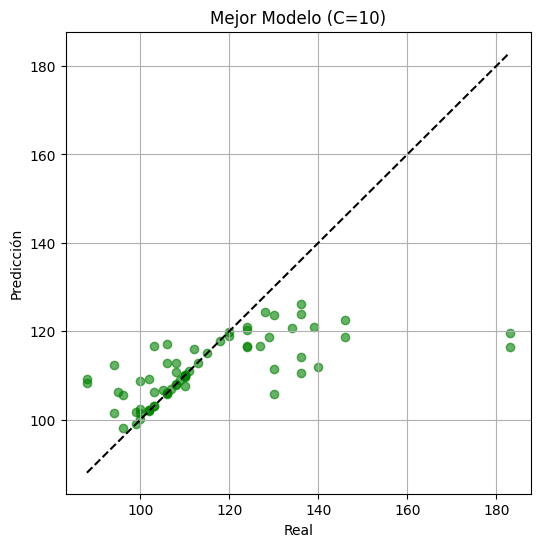

In [ ]:
# ==========================================
# CELDA 8: BÚSQUEDA DE MEJORES HIPERPARÁMETROS (Grid Search)
# ==========================================
from sklearn.model_selection import GridSearchCV

print("Iniciando búsqueda intensiva de hiperparámetros...")

# 1. Definir la rejilla de parámetros a probar
# El paper usó C=1, gamma='scale'. Nosotros probaremos un rango más amplio.
param_grid = {
    'C': [1, 10, 100, 1000],        # Aumentar C fuerza al modelo a ajustar mejor los datos difíciles
    'gamma': ['scale', 0.1, 0.01, 0.001], # Controla la influencia de cada punto
    'epsilon': [0.1, 0.2, 0.5],     # Margen de tolerancia
    'kernel': ['rbf']
}

# 2. Configurar Grid Search con Validación Cruzada
# Usamos el mismo escalado previo
scaler_gs = StandardScaler()
X_scaled = scaler_gs.fit_transform(X)

grid = GridSearchCV(
    SVR(),
    param_grid,
    refit=True,     # Re-entrenar con el mejor modelo encontrado
    verbose=2,      # Mostrar progreso
    cv=5,           # 5-Fold CV
    scoring='neg_root_mean_squared_error' # Optimizar RMSE
)

# 3. Ejecutar búsqueda
grid.fit(X_scaled, Y)

# 4. Resultados
print("\n--- MEJORES PARÁMETROS ENCONTRADOS ---")
print(grid.best_params_)

# 5. Evaluar el nuevo "Mejor Modelo"
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_scaled) # Nota: Evaluamos en todo el set para ver el ajuste (fit)

# Métricas rápidas del mejor modelo
rmse_best = np.sqrt(mean_squared_error(Y, y_pred_best))
r_best, _ = pearsonr(Y, y_pred_best)

print(f"\nNuevo RMSE (Ajuste): {rmse_best:.2f}")
print(f"Nueva Correlación Pearson: {r_best:.4f}")

# Gráfica rápida para ver si ya no es una línea plana
plt.figure(figsize=(6, 6))
plt.scatter(Y, y_pred_best, c='green', alpha=0.6)
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], 'k--')
plt.title(f'Mejor Modelo (C={grid.best_params_["C"]})')
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.grid(True)
plt.show()

Evaluando modelo optimizado (C=10, gamma=0.1)...


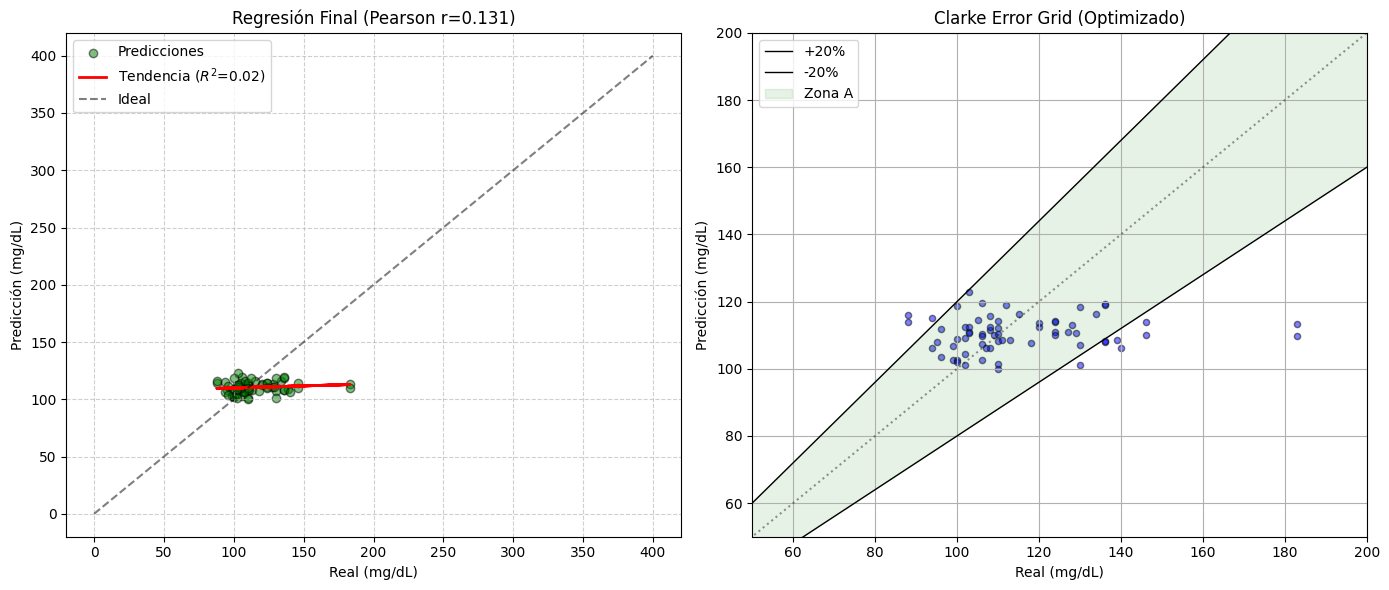


--- RESULTADO FINAL DE LA REPLICACIÓN ---
RMSE (Cross-Validation): 19.17 mg/dL
Correlación Pearson:     0.1308
Muestras en Zona A:      82.09%


In [ ]:
# ==========================================
# CELDA 9: VALIDACIÓN FINAL Y GRÁFICOS (MODELO OPTIMIZADO)
# ==========================================
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

# 1. Configuración con TUS MEJORES HIPERPARÁMETROS
best_C = 10
best_gamma = 0.1
best_epsilon = 0.1

print(f"Evaluando modelo optimizado (C={best_C}, gamma={best_gamma})...")

if len(X) > 0:
    # Preparar validación cruzada
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    y_real_final = []
    y_pred_final = []

    # Bucle de validación (Entrenamiento real)
    for train_index, test_index in kf.split(X):
        # Separar
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = Y[train_index], Y[test_index]

        # Escalar
        scaler_final = StandardScaler()
        X_train_fold = scaler_final.fit_transform(X_train_fold)
        X_test_fold = scaler_final.transform(X_test_fold)

        # Entrenar SVR con parámetros optimizados
        svr_final = SVR(kernel='rbf', C=best_C, epsilon=best_epsilon, gamma=best_gamma)
        svr_final.fit(X_train_fold, y_train_fold)

        # Predecir
        pred = svr_final.predict(X_test_fold)

        y_real_final.extend(y_test_fold)
        y_pred_final.extend(pred)

    # Convertir a arrays
    y_real = np.array(y_real_final)
    y_pred = np.array(y_pred_final)

    # --- GRÁFICOS FINALES ---
    plt.figure(figsize=(14, 6))

    # 1. Regresión
    plt.subplot(1, 2, 1)
    corr, _ = pearsonr(y_real, y_pred)
    m, b = np.polyfit(y_real, y_pred, 1)

    plt.scatter(y_real, y_pred, c='green', alpha=0.5, edgecolors='k', label='Predicciones')
    plt.plot(y_real, m*y_real + b, 'r-', lw=2, label=f'Tendencia ($R^2$={corr**2:.2f})')
    plt.plot([0, 400], [0, 400], 'k--', alpha=0.5, label='Ideal')

    plt.title(f'Regresión Final (Pearson r={corr:.3f})')
    plt.xlabel('Real (mg/dL)')
    plt.ylabel('Predicción (mg/dL)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # 2. Clarke Error Grid
    plt.subplot(1, 2, 2)
    plt.scatter(y_real, y_pred, c='blue', alpha=0.5, s=20, edgecolors='k')

    # Líneas de zonas (Simplificadas)
    plt.plot([0, 400], [0, 400], 'k:', alpha=0.4)
    plt.plot([0, 400], [0, 480], 'k-', lw=1, label='+20%')
    plt.plot([0, 400], [0, 320], 'k-', lw=1, label='-20%')

    # Zona A Coloreada
    x_g = np.linspace(0, 400, 100)
    plt.fill_between(x_g, x_g*0.8, x_g*1.2, color='green', alpha=0.1, label='Zona A')

    plt.title('Clarke Error Grid (Optimizado)')
    plt.xlabel('Real (mg/dL)')
    plt.ylabel('Predicción (mg/dL)')
    plt.xlim(50, 200) # Zoom en zona de interés (tu dataset está entre 70-185)
    plt.ylim(50, 200)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Métricas Finales
    rmse_final = np.sqrt(mean_squared_error(y_real, y_pred))

    # Zona A %
    diff_rel = np.abs((y_real - y_pred) / y_real)
    in_zone_a = np.sum(diff_rel <= 0.20)
    percent_a = (in_zone_a / len(y_real)) * 100

    print(f"\n--- RESULTADO FINAL DE LA REPLICACIÓN ---")
    print(f"RMSE (Cross-Validation): {rmse_final:.2f} mg/dL")
    print(f"Correlación Pearson:     {corr:.4f}")
    print(f"Muestras en Zona A:      {percent_a:.2f}%")

else:
    print("Faltan datos.")